In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import librosa
import matplotlib.pyplot as plt
from google.colab import drive
import glob
import os
import cv2
from torch.autograd import Variable, grad
import torchvision.utils
from torchvision.utils import save_image
drive.mount('/content/drive')

# Define paths (Replace with your actual paths)
real_dataset_path = '/content/drive/MyDrive/dataset/TeamDeepwave/dataset/KaggleDataset/real'
fake_dataset_path = '/content/drive/MyDrive/dataset/TeamDeepwave/dataset/KaggleDataset/fake'
GENERATED_PATH = '/content/drive/MyDrive/dataset/TeamDeepwave/dataset/KaggleDataset/generated'
CHECKPOINT_PATH = '/content/drive/MyDrive/dataset/TeamDeepwave/dataset/KaggleDataset/model_checkpoints'

# Hyperparameters
num_epochs = 100
learning_rate = 0.0002
batch_size = 64
latent_dim = 100
LAMBDA_GP = 10

# Function to load and preprocess audio data
def load_audio_and_preprocess(file_path, sr=22050, max_length=128):
    y, _ = librosa.load(file_path, sr=sr)
    stft = librosa.stft(y)
    spectrogram = librosa.amplitude_to_db(np.abs(stft), ref=np.max)

    if spectrogram.shape[1] < max_length:
        spectrogram = np.pad(spectrogram, pad_width=((0, 0), (0, max_length - spectrogram.shape[1])), mode='constant')
    else:
        spectrogram = spectrogram[:, :max_length]

    spectrogram = (spectrogram - np.min(spectrogram)) / (np.max(spectrogram) - np.min(spectrogram))
    spectrogram = cv2.resize(spectrogram, (128, 128))
    return spectrogram

# Load and preprocess data
real_spectrograms = [load_audio_and_preprocess(file) for file in glob.glob(real_dataset_path + '/*.wav')]
fake_spectrograms = [load_audio_and_preprocess(file) for file in glob.glob(fake_dataset_path + '/*.wav')]
all_spectrograms = np.concatenate([real_spectrograms, fake_spectrograms])
all_labels = np.concatenate([np.ones(len(real_spectrograms)), np.zeros(len(fake_spectrograms))])

# Shuffle data
shuffle_indices = np.random.permutation(len(all_spectrograms))
all_spectrograms = all_spectrograms[shuffle_indices]
all_labels = all_labels[shuffle_indices]

# Convert to PyTorch tensors and create DataLoader
all_spectrograms_tensor = torch.tensor(all_spectrograms, dtype=torch.float32).unsqueeze(1)
all_labels_tensor = torch.tensor(all_labels, dtype=torch.float32).unsqueeze(1)
dataset = torch.utils.data.TensorDataset(all_spectrograms_tensor, all_labels_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Create labels and combine data
all_spectrograms = np.concatenate([real_spectrograms, fake_spectrograms])
all_labels = np.concatenate([np.ones(len(real_spectrograms)), np.zeros(len(fake_spectrograms))])

class PhaseShuffle(nn.Module):
    def __init__(self, shift_factor):
        super(PhaseShuffle, self).__init__()
        self.shift_factor = shift_factor

    def forward(self, x):
        if self.shift_factor == 0:
            return x

        k_list = torch.Tensor(x.shape[0]).random_(0, 2 * self.shift_factor + 1) - self.shift_factor
        k_list = k_list.numpy().astype(int)

        k_map = {}
        for idx, k in enumerate(k_list):
            k = int(k)
            if k not in k_map:
                k_map[k] = []
            k_map[k].append(idx)

        x_shuffle = x.clone()

        for k, idxs in k_map.items():
            if k > 0:
                x_pad = x[idxs].detach().cpu().numpy()  # Detach before converting to NumPy
                x_pad = np.pad(x_pad, ((0, 0), (0, 0), (k, 0)), mode='reflect')
                x_shuffle[idxs] = torch.from_numpy(x_pad).to(x.device)
            else:
                x_pad = x[idxs].detach().cpu().numpy()  # Detach before converting to NumPy
                x_pad = np.pad(x_pad, ((0, 0), (0, 0), (0, -k)), mode='reflect')
                x_shuffle[idxs] = torch.from_numpy(x_pad).to(x.device)

        return x_shuffle


# Define GAN Architecture
class Generator(nn.Module):
    def __init__(self, input_dim=100, output_channels=1, image_size=128):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(input_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(64, output_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, input_channels=1, image_size=128, shift_factor=2):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(input_channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # Add Phase Shuffle layer here
            PhaseShuffle(shift_factor), # New line
        )

        # Flatten and linear layers after the main convolutional block
        self.flatten = nn.Flatten()
        self.linear_layers = nn.Sequential(
            nn.Linear(512 * 8 * 8, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        x = self.main(input)
        x = self.flatten(x)
        return self.linear_layers(x)

# Function to compute gradient penalty (for WGAN-GP)
def compute_gradient_penalty(D, real_samples, fake_samples, device):
    """Calculates the gradient penalty loss for WGAN GP"""
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(real_samples.size(0), 1, device=device)
    gradients = grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

def save_spectrogram_image(gen, input_noise, epoch, batch_num, save_path):
    """Generate and save images from the generator."""
    with torch.no_grad():
        gen.eval()
        samples = gen(input_noise)
        gen.train()
        samples = samples.view(-1, 1, 128, 128)
        save_image(samples, os.path.join(save_path, f'image_at_epoch_{epoch:04d}_batch_{batch_num:04d}.png'), nrow=8, normalize=True)

# Global variable upper the train_gan
fixed_noise = torch.randn(9, latent_dim, 1, 1, device=device)

# Training Loop (Modified with WGAN-GP and Phase Shuffle)
def train_gan(generator, discriminator, dataloader, num_epochs=num_epochs, lr=learning_rate, device="cuda"):
    criterion = nn.MSELoss()  # Least Squares Loss for WaveGAN
    optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

    G_losses = []
    D_losses = []

    # Fixed noise for visualization
    fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)
    iters = 0
    num_batches = len(dataloader)  # Calculate the total number of batches

    for epoch in range(num_epochs):
        for i, (real_samples, _) in enumerate(dataloader):
            real_samples = real_samples.to(device)

            # Train Discriminator (Critic)
            for _ in range(5):  # Train discriminator 5 times for each generator update
                optimizer_D.zero_grad()
                real_validity = discriminator(real_samples)
                z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
                fake_samples = generator(z).detach()  # Detach for discriminator
                fake_validity = discriminator(fake_samples)

                # Gradient penalty
                gradient_penalty = compute_gradient_penalty(discriminator, real_samples, fake_samples, device)

                # Adversarial loss (WGAN-GP)
                d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + LAMBDA_GP * gradient_penalty
                d_loss.backward()
                optimizer_D.step()
                D_losses.append(d_loss.item())

            # Train Generator
            optimizer_G.zero_grad()
            fake_samples = generator(z)
            fake_validity = discriminator(fake_samples)
            g_loss = -torch.mean(fake_validity)
            g_loss.backward()
            optimizer_G.step()
            G_losses.append(g_loss.item())

            iters += 1
            if iters % 100 == 0:
                print(f"Epoch [{epoch}/{num_epochs}] Batch {i}/{len(dataloader)} \
                      Loss D: {d_loss:.4f}, loss G: {g_loss:.4f}")

                save_checkpoint(generator, discriminator, optimizer_G, optimizer_D, epoch, i, CHECKPOINT_PATH)
                save_spectrogram_image(generator, fixed_noise, epoch, i, GENERATED_PATH)

    return generator, G_losses, D_losses


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
# Initialize models and determine device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)
print(f"Using device: {device}")


Using device: cpu


Generated spectrograms shape: torch.Size([9, 1, 64, 64])
Spectrogram shape to visualize: torch.Size([64, 64])
Spectrogram shape to visualize: torch.Size([64, 64])
Spectrogram shape to visualize: torch.Size([64, 64])
Spectrogram shape to visualize: torch.Size([64, 64])
Spectrogram shape to visualize: torch.Size([64, 64])
Spectrogram shape to visualize: torch.Size([64, 64])
Spectrogram shape to visualize: torch.Size([64, 64])
Spectrogram shape to visualize: torch.Size([64, 64])
Spectrogram shape to visualize: torch.Size([64, 64])


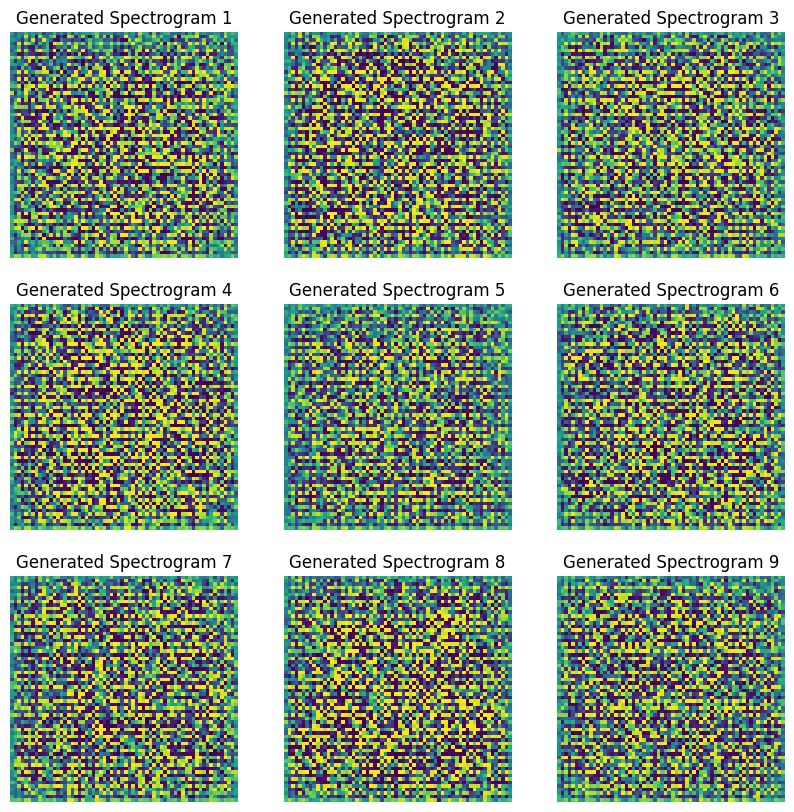

In [43]:
# Generate spectrograms
generated_spectrograms = generator(fixed_noise).detach().cpu()
print("Generated spectrograms shape:", generated_spectrograms.shape)  # Add for debugging

# Visualize generated spectrograms (only first 9 for demonstration)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    spectrogram_to_visualize = generated_spectrograms[i].squeeze()
    print("Spectrogram shape to visualize:", spectrogram_to_visualize.shape)  # Add for debugging
    plt.imshow(spectrogram_to_visualize, cmap='viridis', origin='lower', aspect='auto')
    plt.title(f'Generated Spectrogram {i + 1}')
    plt.axis('off')

plt.show()
